# Time Series EDA
- single continuous variable over time

## Setup

°F = (K - 273.15) x 1.8000 + 32.00

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [4]:
df = pd.read_csv('sa_temps.csv', index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

df.head(10)

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00
Shape: (45252, 1)


,temp
datetime,
2012-10-01 13:00:00,61.052000
2012-10-01 14:00:00,61.076568
2012-10-01 15:00:00,61.139294
2012-10-01 16:00:00,61.202020
2012-10-01 17:00:00,61.264747
2012-10-01 18:00:00,61.327473
2012-10-01 19:00:00,61.390200
2012-10-01 20:00:00,61.452926
2012-10-01 21:00:00,61.515652


- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Data Splitting

- Ideally all splits contain a season
- Human-based
- Percentage based
- Cross Validation

### Percentage-Based

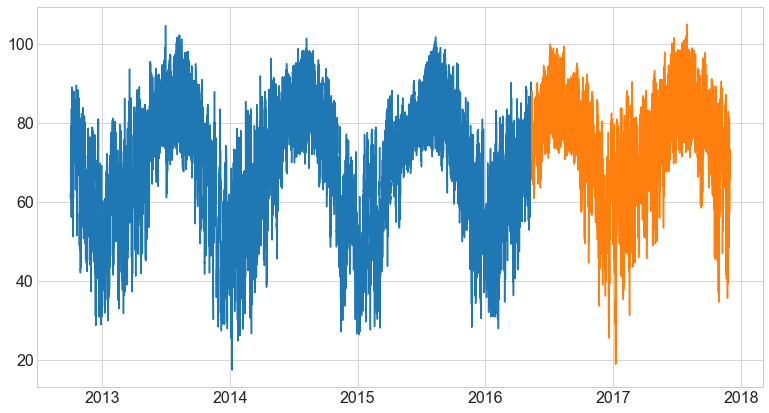

In [5]:
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

### Human-Based

In [ ]:
train = df[:'2016'] # includes 2016
test = df['2017']

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

## Visualizations

In [ ]:
y = train.temp
y.head()

### Don't consider the time series

In [ ]:
y.plot.hist()

- by month
- by weekday

### Visualize the target over time

In [ ]:
y.plot()

In [ ]:
y.resample('6H').mean().plot(title='6 hour average')

In [ ]:
y.resample('2W').mean().plot(title='2 week average')

In [ ]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

In [ ]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().rolling(3).mean().plot(alpha=.5, label='3 day')
y.resample('D').mean().rolling(7).mean().plot(alpha=8, label='1 week')
plt.legend()

### Visualize change over time

In [ ]:
y.resample('W').mean().diff().plot(title='Average week-to-week change in temperature')

In [ ]:
y.resample('M').mean().diff().plot(title='Average month-to-month change in temperature')

### Seasonal Plot

In [ ]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

### Seasonal Subseries Plot

In [ ]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), ls='--')
    ax.set(xlabel='')
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

### Lag Plot

In [ ]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

In [ ]:
train['y(t + 1)'] = train.temp.shift(-1)
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

In [ ]:
del train['y(t + 1)']

In [ ]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

In [ ]:
weekly = train.resample('W').mean()
weekly['12_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='12_weeks_out')
weekly

In [ ]:
weekly = train.resample('W').mean()
weekly['half_a_year_later'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 13))
weekly

In [ ]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=26)

### Autocorrelation Plot

In [ ]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

### Seasonal Decomposition

In [ ]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

In [ ]:
decomposition.iloc[:, 1:].plot()

In [ ]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

### Categories over time

In [ ]:
train = train.resample('D').mean()
# create a categorical feature
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').mean()

In [ ]:
(train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in the month')

In [ ]:
ax = (train['2015']
 .groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black')
)
labels = [pd.to_datetime(t.get_text()).strftime('%B') for t in ax.get_xticklabels()]
ax.set_xticklabels(labels)

## `strftime`

In [ ]:
ax = y.groupby(y.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

## Matplotlib Dates

In [ ]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('W').mean()

ax.plot(weekly.index, weekly)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))